In [36]:
import csv
import pandas as pd
# from pandas import Timestamp
from time import mktime, strftime, strptime
from datetime import datetime
from tqdm.auto import tqdm, trange

# 1. 挑選股票紀錄


- 先讀入指定標籤中(上市櫃、年分)的紀錄，以及指定的欄位資訊

In [37]:
# 讀取股市資料
pick_cols = ['證券代碼','年月日','收盤價(元)','成交量(千股)']
market_raw = pd.read_excel('./bda2023_mid_dataset/stock_data_2019-2023.xlsx', \
    sheet_name=['上市2019', '上市2020', '上市2021', '上市2022', '上市2023'], usecols=pick_cols)
market_raw['上市2023'].head()

證券代碼         年月日  收盤價(元)  成交量(千股)
0    0050 元大台灣50  2023/03/24  122.20    13919
1   0051 元大中型100  2023/03/24   57.40       41
2      0052 富邦科技  2023/03/24  110.10      383
3      0053 元大電子  2023/03/24   61.30        5
4  0055 元大MSCI金融  2023/03/24   21.83      220

- 從中挑出指定的股票代碼，本次實驗挑選的是 "2603 長榮"
- 因為讀取全部股票紀錄較花時間。挑出後，存成檔案做為紀錄點，方便後續使用

In [38]:
# 取出指定代碼股票紀錄
# ticks = ['2603 長榮','2609 陽明', '2610 華航', '2618 長榮航', '0050 元大台灣50']
ticks = ['2603 長榮']

# 整理出存檔路徑
f_path = []
for i in range(len(ticks)):
    path_str = ticks[i]
    f_path.append(f'./ticks_data/{path_str[0:4]}_19-23.csv')

# 篩選
for i in range(len(ticks)):   
    tmp_df = pd.DataFrame()  
    for market_year in market_raw:
        tmp = market_raw[market_year].loc[market_raw[market_year]['證券代碼'] == ticks[i], :]
        tmp = tmp.iloc[::-1]
        tmp_df = pd.concat([tmp_df, tmp], ignore_index=True)
        
    # Write save points to file
    # 繁中字編碼可改 'utf-8' or 'big5'
    tmp_df.to_csv(f_path[i], encoding='big5', index=False)
    
# head = tmp_df.columns  # 取出欄位定義
# print(len(tmp_df.index)) 
# tmp_df.head()

- 從檔案中讀取指定代碼的紀錄

In [39]:
ticks = ['2603 長榮']
market_data = {}

# 讀檔
for tick in ticks:
    market_data[tick] = pd.read_csv(f'./ticks_data/{tick[0:4]}_19-23.csv', delimiter=',', encoding='big5',index_col=False)
    # 從csv檔讀出時，時間格式會變成windows樣式，要再把格式轉回datetime
    market_data[tick]['年月日'] = market_data[tick]['年月日'].apply( \
        lambda x: datetime.fromtimestamp(mktime(strptime(x, '%Y/%m/%d'))))
    
print(type(market_data[tick]['年月日'][0]))
head = market_data[ticks[0]].columns
print(head)
market_data[ticks[0]].head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Index(['證券代碼', '年月日', '收盤價(元)', '成交量(千股)'], dtype='object')


證券代碼        年月日   收盤價(元)  成交量(千股)
0  2603 長榮 2019-01-02  11.7884     5111
1  2603 長榮 2019-01-03  11.7389     5048
2  2603 長榮 2019-01-04  11.4912    12347
3  2603 長榮 2019-01-07  11.8380     7842
4  2603 長榮 2019-01-08  11.7389     4366

# 2.篩選文章和標註(Labeling)

## 標註
- 定義labeling method: 我們選擇不標"漲"或"跌"。而是將漲跌%數作為標記，不做分類而是迴歸。
- rol_window 控制要計算幾天間的價差
- 回傳的標註可為dict { date: label } 或dataframe型別

In [40]:
# Mark labels
def markLabels(data=pd.DataFrame, n_date: int=1, ret_type: str='dict') -> pd.DataFrame | dict:
    # return as Dataframe
    if ret_type == 'df':
        tmp = list()
        for i in data.index:
            if i<(len(data.index) - n_date):
                period_chg = data['收盤價(元)'][i+n_date]-data['收盤價(元)'][i]
                period_pct = (period_chg/(data['收盤價(元)'][i]+0.000001))*100.0            
                tmp.append(round(period_pct, 0))
                
        tmp.extend([0.0]*n_date)    
        data['Label'] = tmp  
        return data

    # return as dict
    else:
        labels = {}
        for i in data.index:
            if i<(len(data.index) - n_date):
                period_chg = data['收盤價(元)'][i+n_date]-data['收盤價(元)'][i]
                period_pct = (period_chg/(data['收盤價(元)'][i]+0.000001))*100.0
                # dt = datetime.fromtimestamp(mktime(strptime(data['年月日'][i], '%Y/%m/%d')))  # 上面已轉換
                k = datetime.strftime(data['年月日'][i], '%Y-%m-%d')
                labels[data['年月日'][i]] = round(period_pct, 0)
        print(type(data['年月日'][i]))
        return labels 
# test = markLabels(data_2603, 3)
# data_2603.loc[data_2603['Label']>10, :]
# data_2603.loc[data_2603['Label']>0, ['年月日']]

- 將資料和標註合併的method，同時能設定條件，篩出指定的label

In [41]:
def matchDataLabel(data: list|pd.DataFrame, labels: dict|list) -> dict:
    tmp = sorted(set(data))
    ret_labels = dict()
    for time in tmp:
        # time = datetime.strftime(time, '%Y-%m-%d')
        if time in labels:
        # if time in labels and labels[time] >= 5.0:  # 設定條件
            ret_labels[time] = labels[time]
    return ret_labels

- 標註主程式，extracted_time是key為date、value為label的dict

In [42]:
labels = markLabels(market_data[ticks[0]], n_date=3)
extracted_time = matchDataLabel(market_data[tick]['年月日'], labels)    

print(f'Feature length: {len(extracted_time.keys())}')
# extracted_time

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Feature length: 1023


In [43]:
print(extracted_time)

{Timestamp('2019-01-02 00:00:00'): 0.0, Timestamp('2019-01-03 00:00:00'): 0.0, Timestamp('2019-01-04 00:00:00'): 4.0, Timestamp('2019-01-07 00:00:00'): 0.0, Timestamp('2019-01-08 00:00:00'): 1.0, Timestamp('2019-01-09 00:00:00'): -2.0, Timestamp('2019-01-10 00:00:00'): 1.0, Timestamp('2019-01-11 00:00:00'): 0.0, Timestamp('2019-01-14 00:00:00'): 2.0, Timestamp('2019-01-15 00:00:00'): -0.0, Timestamp('2019-01-16 00:00:00'): 0.0, Timestamp('2019-01-17 00:00:00'): 1.0, Timestamp('2019-01-18 00:00:00'): -1.0, Timestamp('2019-01-21 00:00:00'): -0.0, Timestamp('2019-01-22 00:00:00'): -0.0, Timestamp('2019-01-23 00:00:00'): 1.0, Timestamp('2019-01-24 00:00:00'): 0.0, Timestamp('2019-01-25 00:00:00'): -1.0, Timestamp('2019-01-28 00:00:00'): -1.0, Timestamp('2019-01-29 00:00:00'): -1.0, Timestamp('2019-01-30 00:00:00'): -1.0, Timestamp('2019-02-11 00:00:00'): -0.0, Timestamp('2019-02-12 00:00:00'): -0.0, Timestamp('2019-02-13 00:00:00'): 0.0, Timestamp('2019-02-14 00:00:00'): 0.0, Timestamp('20

- 計算漲和跌的分布，後面評估用

In [44]:
truth_list = []
for m in range(39):
    start = pd.Timestamp(year=2020, month=1, day=1)+ pd.DateOffset(months=m)
    end = start + pd.DateOffset(months=1, days=-1)
    up = 0
    down = 0
    for d in extracted_time.keys():
        if d >= start and d <= end:
            if extracted_time[d] > 0:
                up+=1
            elif extracted_time[d] < 0:
                down+=1
    
    truth_list.append([up, down])
# truth_list

## 讀取文章

- 設定讀檔路徑

In [10]:
# file path
file_paths = [
    'bda2023_mid_bbs_2019-2021.csv',
    'bda2023_mid_bbs_2022-2023.csv',
    'bda2023_mid_forum_2020.csv',
    'bda2023_mid_forum_2021.csv',
    'bda2023_mid_forum_2022-2023.csv',   
    # 'bda2023_mid_news_2020.csv',
    # 'bda2023_mid_news_2021.csv',
    # 'bda2023_mid_news_2022.csv',
    # 'bda2023_mid_news_2023.csv',
    # 'bda2023_mid_news_2022-2023.csv', 
]

news_paths = [
    'bda2023_mid_news_2020.csv',
    'bda2023_mid_news_2021.csv',
    'bda2023_mid_news_2022.csv',
    'bda2023_mid_news_2023.csv',
    'bda2023_mid_news_2022-2023.csv',
]

- 讀取文章至dataframe

In [11]:
# Read file
articles_df = pd.DataFrame()
for file in tqdm(news_paths):
    tmp_df = pd.read_csv('./bda2023_mid_dataset/'+file, delimiter=',', encoding='utf-8',
                       usecols=['post_time', 'title', 'content'])
    articles_df = pd.concat([articles_df, tmp_df], ignore_index=True)
print(f'num of articles: {len(articles_df.index)}')
articles_df.head()

100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

num of articles: 925791


post_time                      title   
0  2020-01-01 00:28:00  財政部、內政部推一站式服務 不動產移轉登記一次搞定  \
1  2020-01-01 00:29:00    IMF：Q3美元佔全球外匯儲備比重升至一年新高   
2  2020-01-01 01:15:00     騰訊集團以34億美元 收購環球音樂10%股權   
3  2020-01-01 03:23:00   加幣漲幅勇冠G10 瑞信：央行政策是明年主要風險   
4  2020-01-01 03:41:00                   【歐股盤後】收低   

                                             content  
0  為避免民眾辦理不動產買賣移轉登記，需要稅務、地政機關兩邊跑，財政部與內政部合作成立「不動產移...  
1  週二 (31 日) 國際貨幣組織公布 (IMF) 數據顯示，今年第 3 季，美元在全球外匯儲...  
2  外電報導，騰訊集團 (0700-HK) 與法國多媒體集團威望迪 (Vivendi)，在經過了...  
3  週二 (31 日)，受到中國強勁經濟數據支持，加元兌美元匯率升至 14 個月高位，且年度漲幅...  
4  （中央社台北2020年1月1日電）歐洲股市在今年最後一個交易日交易清淡，倫敦和巴黎股市收低，...

- 統一時間格式，可為pd.Timestamp或Datetime.datetime

In [12]:
# 轉換時間格式
articles_df['post_time'] = pd.to_datetime(articles_df['post_time']).dt.normalize() # 將時間統一到 00:00:00
# articles_df['post_time'] = articles_df['post_time'].dt.floor('D')

# 上面methods執行會比下面快
# articles_df['post_time'] = pd.to_datetime(articles_df['post_time']).dt.date
print(articles_df['post_time'][5130])
# 測試取出日期屬性  index 5130 = 2019-03-30
articles_df['post_time'][5130].month

2020-01-08 00:00:00


1

- 將標記移置train_df上

In [13]:
train_df = articles_df.copy()
train_df['label'] = train_df['post_time'].apply(lambda x: extracted_time.get(x, None))
# train_df['label'] = train_df['post_time'].apply(lambda x: extracted_time.get(datetime.strftime(x, '%Y-%m-%d')))

- 根據標註挑選

In [14]:
train_df = train_df.loc[train_df['label'] >= 5.0, :]
train_df = train_df.reset_index(drop=True)
# [22050] = '2020-01-30'
# train_df['label'][22050]
# ans = lambda x: extracted_time.get(datetime.strftime(x, '%Y-%m-%d'), None)
# ans(train_df['post_time'][22050])
print(len(train_df['label']))
train_df.tail(5)

173888


post_time                      title   
173883 2023-03-08          【公告】大億董事會通過關係人捐贈案  \
173884 2023-03-08       2月筆電出貨微幅回溫 緯創Q1營收逐月升   
173885 2023-03-08          通膨問題緩解 拜登支持度升至42％   
173886 2023-03-08  歐元區去年第四季GDP零成長 不影響ECB升息腳步   
173887 2023-03-08       鮑爾放鷹 美債驚見1981年來最嚴重倒掛   

                                                  content  label  
173883  日 期：2023年03月08日公司名稱：大億 (1521)主 旨：大億董事會通過關係人捐贈案...    6.0  
173884  緯創（3231）2月筆電出貨微幅回溫、達120萬台，帶動月營收亦月增逾一成、達620.67億...    6.0  
173885  路透／益普索（Ipsos）最新調查顯示，美國總統拜登的民意支持度如今升至42％，創下去年6月...    6.0  
173886  歐盟統計局8日公布，歐元區去年第四季國內生產毛額（GDP）終值由上次預估的季增0.1％下修至...    6.0  
173887  聯準會（Fed）主席鮑爾7日赴國會作證時高唱鷹調，刺激美國2年期公債殖利率飆破5％，創下20...    6.0

## 斷詞

- 引入斷詞工具monpa所需套件

In [15]:
import monpa
from monpa import utils
import torch
from collections import Counter

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


- 確認GPU狀態

In [16]:
if torch.cuda.is_available():
    monpa.use_gpu(True)

def print_gpu_memory():
    gpu_state = torch.cuda.is_available()
    total_m = torch.cuda.get_device_properties(0).total_memory/(1024**2)
    reserved_m = torch.cuda.memory_reserved(0)/(1024**2)
    allocated_m = torch.cuda.memory_allocated(0)/(1024**2)
    free_m = reserved_m-allocated_m
    
    print('GPU state: {:s}\nGPU total memory: {:.2f} MB\nReserve for excution: {:.2f} MB\nExecution allocated: {:.2f} MB\nFree memory: {:.2f} MB'\
        .format('Available' if gpu_state else 'None', total_m, reserved_m, allocated_m, free_m))

print_gpu_memory()

GPU state: Available
GPU total memory: 11263.75 MB
Reserve for excution: 0.00 MB
Execution allocated: 0.00 MB
Free memory: 0.00 MB


- 將標題和內容合併

In [17]:
# Combine 'title' & 'content'
def combine_str(series):
    tmp_str = ''
    try:
        tmp_str = series['title']+'。'+series['content']
    except:
        tmp_str = str(series['title'])+'。'+str(series['content'])
    
    return tmp_str    
    
train_df['combined'] = train_df.apply(combine_str, axis=1)

- 定義斷詞method

In [18]:
def word_Tokenize(contents: pd.DataFrame, forW2V: bool=False):
    err_data = list()
    tf_counter = Counter()
    df_counter = Counter()
    total = len(contents.index)
    
    if forW2V:
        W2V = list()
    
    for i in tqdm(contents.index, desc="Cutting process: "):
        total -= 1
        if  total % 5000 == 0:
            print_gpu_memory()
            # Clear gpu cache
            # torch.cuda.empty_cache()           
                
        df_tmp = Counter()
        sentence_list = utils.short_sentence(contents['combined'][i])
        result_cut = monpa.cut_batch(sentence_list) #斷詞 GPU加速method
        
        # print(result_cut)
        tmp_row = list()
        for terms in result_cut:            
            if len(terms) > 0: 
                term = terms[0].strip() #去除前後多餘空白
                # print(term)
                #若詞長>1 (排除標點符號、單字)，排除英數字
                if(len(term)>1 and len(term)<=8) \
                    and (not term.isdigit()): 
                    # print(type(term))
                    tf_counter[term]+=1 #tf加1
                    if(df_tmp[term]==0): #若本篇之前不曾出現
                        df_tmp[term]=1 #df標為1
                    tmp_row.append(term)
                    
        if forW2V:
            W2V.append(tmp_row)
        
        df_counter+=df_tmp # 累加多篇df        
    
    if forW2V:
        f = open('./mid-term/Word2Vec/raw.csv', 'w', newline='', encoding='utf-8')
        writer = csv.writer(f, delimiter=',')
        for items in W2V:
            writer.writerow(items)
        f.close()
        
    return tf_counter, df_counter, err_data    

- 斷詞主程式

In [19]:
result = []

# Cutting main proc
print_gpu_memory()
# tf, df, err = word_Tokenize(train_df, False)
# print(f'tf counter result: \n{tf.most_common(100)}.')
# print(f'df counter result: \n{df.most_common(100)}.')
# print(f'Error avoid {len(err)} times.')

GPU state: Available
GPU total memory: 11263.75 MB
Reserve for excution: 0.00 MB
Execution allocated: 0.00 MB
Free memory: 0.00 MB


## 外部引入已斷詞資料

- 讀取檔案

In [45]:
token_OK = pd.read_csv('./terms_data/mid_news_OK.csv', delimiter=',', encoding='utf-8')
token_OK.head()

post_time                                            content
0  2020-01-01   財政部 內政部 一站式 服務 動產 移轉 登記 搞定 避免 民眾 辦理 動產 買賣 移轉 ...
1  2020-01-01   IMF 美元 全球 外匯 儲備 比重 新高 週二 31 國際貨幣組織 公布 IMF 數據 ...
2  2020-01-01   騰訊集團 34億 美元 收購 環球 音樂 10 股權 外電 報導 騰訊集團 0700 HK...
3  2020-01-01   加幣 漲幅 勇冠 10 瑞信 央行 政策 明年 主要 風險 週二 31 受到 中國 強勁 ...
4  2020-01-01   股盤 收低 中央社 台北 2020年 1月 1日 歐洲 股市 今年 最後 交易日 交易 清...

- 調整時間格式，併入標註

In [46]:
token_OK['post_time'] = pd.to_datetime(token_OK['post_time']).dt.normalize()
token_OK['label'] = token_OK['post_time'].apply(lambda x: extracted_time.get(x, None))
print(len(token_OK['label']))
token_OK['label'].fillna(0, inplace=True)
token_OK.head()

631837


post_time                                            content  label
0 2020-01-01   財政部 內政部 一站式 服務 動產 移轉 登記 搞定 避免 民眾 辦理 動產 買賣 移轉 ...    0.0
1 2020-01-01   IMF 美元 全球 外匯 儲備 比重 新高 週二 31 國際貨幣組織 公布 IMF 數據 ...    0.0
2 2020-01-01   騰訊集團 34億 美元 收購 環球 音樂 10 股權 外電 報導 騰訊集團 0700 HK...    0.0
3 2020-01-01   加幣 漲幅 勇冠 10 瑞信 央行 政策 明年 主要 風險 週二 31 受到 中國 強勁 ...    0.0
4 2020-01-01   股盤 收低 中央社 台北 2020年 1月 1日 歐洲 股市 今年 最後 交易日 交易 清...    0.0

- 再篩選，設定label條件

In [47]:
feature_df = token_OK.copy()
feature_df = feature_df.loc[abs(feature_df['label']) >= 0.5, :]  # 設定label條件
feature_df = feature_df.reset_index(drop=True)
print(len(feature_df['label']))
feature_df.tail(5)

515349


post_time                                            content  label
515344 2023-03-20   舜宇光學 去年 盈利腰斬 降至 人民幣 24億 港股 上市 手機 設備 製造商 舜宇光學 ...   -2.0
515345 2023-03-20   印月 周年慶 消費 桌菜 客套餐 招牌 烤鴨 半價 優惠 藝術 烤鴨 饗宴 台中 餐飲 市...   -2.0
515346 2023-03-20   UN 研究 索馬利亞 旱災 造成 135 死亡 索馬利亞衛生部 世界衛生組織 WHO 聯合...   -2.0
515347 2023-03-20   金融業 危機 升息 可能 暫緩 美股 開盤 漲跌 中央社 紐約 2023年 3月 20日 ...   -2.0
515348 2023-03-20   看準 普發 6000 現金 商機 台中 福華 客房 全民 普發 6,000 現金 終於 隨...   -2.0

# 3. 文章向量化模型

In [48]:
from gensim.models import word2vec, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import csv
import numpy as np
from scipy.spatial.distance import cosine

- 引入已訓練完成的模型

In [49]:
vector_size = 250  # 定義向量維度
vectorize_model = Word2Vec.load('./Word2Vec/models/w2v_x250.model')

- 相關methods

In [97]:
# vectorize_model.wv.most_similar('晶片', topn=20)
# vectorize_model.wv.get_vector('輝達')
# similarity = cosine(BVector, UPdocVector)

- 文章向量method
- for Word2Vec model


In [ ]:
# Word2Vec
def getDocVec_w2v(model, docterms: list, vec_size: int=250):
    docVec = np.zeros(vec_size)
    for term in docterms:
        try:
            docVec += model.wv.get_vector(term)
        except:
            continue
    return docVec/len(docterms)

- for Doc2Vec model
- alpha是步長，steps迭代步數

In [50]:
# Doc2Vec
def getDocVec_d2v(model, docterms: list, vec_size: int=250):
    docVec = np.zeros(vec_size)
    try:
        docVec = model.infer_vector(doc_word=docterms, alpha=0.003, steps=500)
    except:
        pass
    
    return docVec


- 轉換為list of str method

In [51]:
def str2list(input: pd.Series, print_info:bool):
    input = input.apply( lambda x: x.split() )
    input.apply( lambda x: x.pop(0) )
    if print_info:
        print(input.head())

## 迴歸分析模型

- 選用XGBoosting Regressor

In [53]:
import xgboost as xgb
regressor = xgb.XGBRegressor(n_estimators=250, max_depth=8, booster='gbtree', learning_rate=0.75)

In [101]:
# regressor.fit(data, labels)
# pred = regressor.predict()
# regressor.score(x, y)

# 4. 訓練集文章

- 設定 2021 5-7月為訓練集

In [102]:
train_start = pd.Timestamp(year=2020, month=5, day=1)
train_end = train_start + pd.DateOffset(months=3, days=-1)
print("Training period: ", train_start, ", Ends on: ", train_end)

Training period:  2020-05-01 00:00:00 , Ends on:  2020-07-31 00:00:00


In [103]:
train_df = feature_df[feature_df['post_time'].between(train_start, train_end)]
train_df = train_df.reset_index(drop=True)
train_df.tail()

post_time                                            content  label
15583 2020-07-28   弊案 貪污 洗錢罪 12 納吉 滿意 上訴 馬來西亞 相納吉 Najib Razak 今天...    3.0
15584 2020-07-28   Fed 多數 緊急 貸款 計劃 期限 延至 今年 美國 聯準會 Fed 週二 28 日 宣...    3.0
15585 2020-07-28   武漢 肺炎 疫情 衝擊 麥當勞 營收 衰退 30 中央社 芝加哥 2020年 7月 28日...    3.0
15586 2020-07-28   A7S III Sony 影片 拍攝 準備 利器 官方 所有 一切 Sony 新機 A7S...    3.0
15587 2020-07-28   代工 做到 台積電 客製化 需求 258 製程 中央社 記者 蘇思 台北 2020年 7月...    3.0

- 將Content轉為list of str

In [104]:
str2list(train_df['content'], True)

0    [季線, 狹幅, 震盪, 瞄準, HELP, 進擊, 記者, 陳鑫, 報導, 台股, 上週,...
1    [狂讚, 台灣, 中國, 眾點, 盲點, 好笑, 新冠, 肺炎, 疫情, 延燒, 政府, 因...
2    [05, 11, 財經, 行事曆, 2020, 05, 11, 財經, 行事曆, 今日, 國...
3    [筆記, 鮑爾, 談話, OPEC, 每月, 能源, 展望, 中國, 經濟, 數據, 操盤,...
4    [過度, 依賴, 中國, 蘋果, 量產, AirPods, 比重, 3成, MoneyDJ,...
Name: content, dtype: object


- 獲得文章向量

In [105]:
train_df['DocVec'] = train_df['content'].apply( lambda x: getDocVec(vectorize_model, x) )
train_df.tail()

post_time                                            content  label   
15583 2020-07-28   弊案 貪污 洗錢罪 12 納吉 滿意 上訴 馬來西亞 相納吉 Najib Razak 今天...    3.0  \
15584 2020-07-28   Fed 多數 緊急 貸款 計劃 期限 延至 今年 美國 聯準會 Fed 週二 28 日 宣...    3.0   
15585 2020-07-28   武漢 肺炎 疫情 衝擊 麥當勞 營收 衰退 30 中央社 芝加哥 2020年 7月 28日...    3.0   
15586 2020-07-28   A7S III Sony 影片 拍攝 準備 利器 官方 所有 一切 Sony 新機 A7S...    3.0   
15587 2020-07-28   代工 做到 台積電 客製化 需求 258 製程 中央社 記者 蘇思 台北 2020年 7月...    3.0   

                                                  DocVec  
15583  [-0.27301849844675286, 0.007870422933739796, -...  
15584  [-0.18893430776557407, -0.04461223981005074, 0...  
15585  [-0.358256714251062, 0.06353441880710638, -0.0...  
15586  [-0.11532582994521012, 0.08982224138568472, -0...  
15587  [-0.3408712152036741, -0.040758889710134485, -...

# 5. 測試集文章

- 設定2021 8月為測試集

In [106]:
test_start = train_end + pd.DateOffset(days=1)
test_end = test_start + pd.DateOffset(months=1, days=-1)
print("Testing period: ", test_start, " To ", test_end)

Testing period:  2020-08-01 00:00:00  To  2020-08-31 00:00:00


- 要注意測試集挑選的母體和訓練集不同，訓練集有根據Label條件篩選，而測試集則無
- 選用token_ok而非feature_df

In [107]:
test_df = token_OK[token_OK['post_time'].between(test_start, test_end)]
test_df = test_df.reset_index(drop=True)
test_df.tail()

post_time                                            content  label
7480 2020-08-31   公告 宣德 董事會 決議 修訂 109年度 員工 股權 憑證 發行 辦法 2020年 08...    5.0
7481 2020-08-31   公告 桃禧 109年 07 月份 自結 財務 報告 負債 比率 流動 比率 速動 比率 2...    5.0
7482 2020-08-31   經濟部 製造業 技術 服務業 紓困 開放 申請 經濟部 公告 受理 紓困 3.0 申請 開...    5.0
7483 2020-08-31   豪雨 釀災 印度尼泊爾 過去 至少 41 路透 尼泊爾加德 滿都 印度 阿默達巴德 31 ...    5.0
7484 2020-08-31   TikTok 出售案 9月 1日 宣布 得標 週一 31 日 外媒 引述 消息 人士 說法...    5.0

- 將content轉為list of str

In [108]:
str2list(test_df['content'], True)

0    [貿易, 顧問, 微軟, TikTok, 可能, 中國, 撤資, 路透華盛頓, 傳聞, 美國...
1    [推手, 修姆, 辭世, 前英相布萊爾, 讚揚, 貢獻, 卓越, 路透倫敦, 北愛爾蘭和平,...
2    [iPhone, SE, Google, 殺手級, 新機, Pixel, 4a, 問世, 價...
3    [上揚, 中央社, 台北, 2020年, 8月, 4日, 歐股, 上揚, 原因, 經濟, 數...
4    [建議, 微軟, 買下, TikTok, 公司, 美政府, 微軟, 週日, 證實, TikT...
Name: content, dtype: object


- 取得測試集文章向量

In [109]:
test_df['DocVec'] = test_df['content'].apply( lambda x: getDocVec(vectorize_model, x) )
test_df['DocVec'].head()

0    [-0.13461189286415176, -0.030154600847899365, ...
1    [-0.2429211176092356, -0.10827881329181328, -0...
2    [0.009816042236427123, 0.13853685692006312, -0...
3    [-0.18188376461934538, -0.020597239553231245, ...
4    [-0.25123012696054675, 0.025732903348398395, -...
Name: DocVec, dtype: object

In [110]:
test_df['DocVec'][0].shape

(250,)

# 6. 訓練模型

- 將型別轉為float

In [111]:
train_f = list()
for item in train_df['DocVec']:
    train_f.append(item.astype(float))
train_f

[array([-2.80298660e-01, -6.83956571e-02, -8.08924105e-02, -2.23784417e-01,
         4.74650333e-01, -2.39488637e-01, -2.49756120e-01, -3.03791946e-02,
         2.58401837e-03, -2.20871053e-01, -7.90521431e-02,  2.57673975e-01,
        -2.23577762e-02,  3.35667270e-01,  6.63265406e-02,  2.06245342e-01,
         3.24154447e-01,  1.41136391e-01, -2.36126203e-01, -2.41697894e-01,
        -5.67081207e-01, -3.71123333e-01, -3.29885541e-01,  9.27669349e-02,
         1.11207182e-01, -9.42349686e-02,  2.16824864e-01, -9.60753889e-02,
        -2.05022322e-01, -2.20468642e-01,  1.36164791e-02,  1.70912176e-02,
        -3.37036698e-01, -5.21200905e-01,  1.66880954e-01, -3.37912002e-01,
         2.00169266e-01,  1.26439755e-01, -3.89895749e-01,  7.01979471e-02,
         5.96561270e-02, -1.16881150e-01,  3.21781554e-01, -7.11214373e-02,
        -4.07699310e-01, -1.56702620e-01,  2.52596890e-01,  1.77174803e-01,
        -4.44931047e-01,  6.99774828e-01,  1.39232966e-01,  3.10155810e-01,
        -2.8

In [112]:
len(train_f[0])

250

- Training

In [113]:
regressor.fit(train_f, train_df['label'])
print("Traing Score: ", regressor.score(train_f, train_df['label']))

Traing Score:  0.9981722073551597


- Testing

In [114]:
test_f = list()
for item in test_df['DocVec']:
    test_f.append(item.astype(float))
test_f

test_df['pred_label'] = regressor.predict(test_f)
test_df.tail()

post_time                                            content  label   
7480 2020-08-31   公告 宣德 董事會 決議 修訂 109年度 員工 股權 憑證 發行 辦法 2020年 08...    5.0  \
7481 2020-08-31   公告 桃禧 109年 07 月份 自結 財務 報告 負債 比率 流動 比率 速動 比率 2...    5.0   
7482 2020-08-31   經濟部 製造業 技術 服務業 紓困 開放 申請 經濟部 公告 受理 紓困 3.0 申請 開...    5.0   
7483 2020-08-31   豪雨 釀災 印度尼泊爾 過去 至少 41 路透 尼泊爾加德 滿都 印度 阿默達巴德 31 ...    5.0   
7484 2020-08-31   TikTok 出售案 9月 1日 宣布 得標 週一 31 日 外媒 引述 消息 人士 說法...    5.0   

                                                 DocVec  pred_label  
7480  [-0.2630899855291147, -0.053971975480309686, 0...   -2.896509  
7481  [-0.3387321613948135, 0.03208943522747253, -0....    5.307067  
7482  [-0.2894167145896379, 0.03984838165682089, 0.0...   -1.850187  
7483  [-0.29583564622528014, 0.0014948954047034207, ...    0.754618  
7484  [-0.30374812921444133, 0.014567564714157119, -...   -1.101801

- 評估準確率
- 將同天的predicts平均後，絕對值大於threshold就出手
- 出手後，再看是否和label的漲跌相符


In [115]:
go_up, go_down, miss_up, miss_down = 0, 0, 0, 0
res_df = test_df.groupby('post_time')['pred_label'].mean()
for d in res_df.index:
    if abs(res_df[d]) > 0.5:  # 設定判斷邊際
        gt = extracted_time[pd.Timestamp(d)]
        if res_df[d] > 0 and gt > 0:
            go_up += 1
        elif res_df[d] > 0 and gt < 0:
            miss_up += 1          
        elif res_df[d] < 0 and gt < 0:
            go_down += 1
        else:
            miss_down += 1
    
print("Action percentage: {:.2f}%".format((go_up+go_down+miss_up+miss_down)*100/(truth_list[5][0]+truth_list[5][1])))
print("Test accuracy: {:.2f}%".format((go_up+go_down)*100/(go_up+go_down+miss_up+miss_down)))

Action percentage: 115.38%
Test accuracy: 73.33%


# 7. 移動式訓練和回測

## Preprocessing

- 取得所有文章的向量

In [54]:
str2list(token_OK['content'], print_info=False)  # 轉成 list of str
str2list(feature_df['content'], print_info=False)  # 轉成 list of str
token_OK['DocVec'] = token_OK['content'].apply( lambda x: getDocVec_w2v(vectorize_model, x) )  # 轉成文件向量
feature_df['DocVec'] = feature_df['content'].apply( lambda x: getDocVec_w2v(vectorize_model, x) )  # 轉成文件向量
feature_df.head()

post_time                                            content  label   
0 2020-01-02   銘異 公司 關係人 綠晁 科技 退票 公開 資訊 觀測站 重大 訊息 公告 BR 3060...    2.0  \
1 2020-01-02   2020 01 02 財經 行事 今日 國內外 財經 焦點 BR 台灣 BR 掛牌 冠亞 ...    2.0   
2 2020-01-02   健策 董事會 決議 參與 認購 金利 私募股 3千萬 10.47 3.14 持股 比例 3...    2.0   
3 2020-01-02   三星 華城 晶片廠 突跳電 DRAM NAND 生產線 部分 停擺 MoneyDJ 新聞 ...    2.0   
4 2020-01-02   日產 董座 潛逃 黎巴嫩 律師 戈恩 8日 記者會 中央社 貝魯特 2020年 1月 1日...    2.0   

                                              DocVec  
0  [-0.331191835568573, -0.009906036607348002, -0...  
1  [-0.19751515489730503, 0.1218339784367852, -0....  
2  [-0.2778012848532206, -0.06588439732939029, -0...  
3  [-0.32785865119713564, -0.024740720143330532, ...  
4  [-0.22454993952074703, -0.05425204062757897, -...

## 封裝 method

### Training


In [55]:
def movingTrain(model, data, start, end):
    train = data[data['post_time'].between(start, end)]
    train = train.reset_index(drop=True)
    # print(start, end)
    
    trainf = list()
    if len(train['DocVec']) <= 0:  # 避掉train set為空
        return False
        
    for item in train['DocVec']:
        trainf.append(item.astype(float))
    
    model.fit(trainf, train['label'])
    score = model.score(trainf, train['label'])
    print("Traing Score: {:.4f}".format(score) )
    
    return score > 0

### Testing

In [56]:
def movingTest(model, data, start, end, label_dict, threshold) -> list:
    go_up, go_down, miss_up, miss_down = 0, 0, 0, 0
    
    test = data[data['post_time'].between(start, end)]
    test = test.reset_index(drop=True)
    testf = list()
    if len(test['DocVec']) <= 0: # 避掉test set為空
        return [start, go_up, go_down, miss_up, miss_down]
    for item in test['DocVec']:
        testf.append(item.astype(float))

    test['pred_label'] = model.predict(testf)
    
    res_df = test.groupby('post_time')['pred_label'].mean()
    # print(res_df)
    for d in res_df.index:
        if abs(res_df[d]) > threshold:  # 設定判斷邊際
            if d in label_dict.keys():
                gt = label_dict[pd.Timestamp(d)]
            else: 
                gt = 0
                
            if res_df[d] > 0 and gt > 0:
                go_up += 1
            elif res_df[d] > 0 and gt < 0:
                miss_up += 1          
            elif res_df[d] < 0 and gt < 0:
                go_down += 1
            else:
                miss_down += 1
                
    return [start, go_up, go_down, miss_up, miss_down]

## 主程式

In [57]:
res_record = list()
for mon in trange(36):
    # 設定時間範圍
    train_start = pd.Timestamp(year=2020, month=1, day=1) + pd.DateOffset(months=mon)
    train_end = train_start + pd.DateOffset(months=3, days=-1)
    test_start = train_end + pd.DateOffset(days=1)
    test_end =  test_start + pd.DateOffset(months=1, days=-1)
    
    if movingTrain(regressor, feature_df, train_start, train_end):
        res_record.append(movingTest(regressor, token_OK, test_start, test_end, extracted_time, 0.5))  
    

  0%|          | 0/36 [00:00<?, ?it/s]

Traing Score: 0.9992


  3%|▎         | 1/36 [01:41<58:59, 101.13s/it]

Traing Score: 0.9995


  6%|▌         | 2/36 [03:17<55:52, 98.60s/it] 

Traing Score: 0.9992


  8%|▊         | 3/36 [05:33<1:03:32, 115.54s/it]

Traing Score: 0.9981


 14%|█▍        | 5/36 [09:50<1:03:35, 123.10s/it]

Traing Score: 0.9978


 17%|█▋        | 6/36 [11:49<1:00:43, 121.45s/it]

Traing Score: 0.9976


- 印出測試結果

In [ ]:
print(len(res_record))
print(res_record)

24
[[Timestamp('2021-04-01 00:00:00'), 0, 0, 1, 4], [Timestamp('2021-05-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2021-06-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2021-07-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2021-08-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2021-09-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2021-10-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2021-11-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2021-12-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2022-01-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2022-02-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2022-03-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2022-04-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2022-05-01 00:00:00'), 0, 1, 0, 1], [Timestamp('2022-06-01 00:00:00'), 0, 0, 0, 1], [Timestamp('2022-07-01 00:00:00'), 0, 5, 0, 23], [Timestamp('2022-08-01 00:00:00'), 0, 0, 0, 1], [Timestamp('2022-09-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2022-10-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2022-11-01 00:00:00'), 0, 0, 0, 0], [Timestamp('2022-12-01 00:00:00'), 

In [ ]:
sum(res_record[0][1:5])/4

1.25

In [ ]:
m = 2
months = []
go_list, acc_list = [], []
for result in res_record:
    m += 1
    if sum(result[1:5]) == 0:
        go = 0
        acc = 0
    else:
        go = sum(result[1:5]) / sum(truth_list[m])
        acc = sum(result[1:3]) / sum(result[1:5])
    
    months.append(f'{result[0].year}/{result[0].month}')
    go_list.append(go)
    acc_list.append(acc)
    
    print('{:d}年{:d}月測試結果: 出手率 {:.2f}%, 準確率 {:.2f}%'.format(result[0].year, result[0].month, go*100, acc*100))

ZeroDivisionError: division by zero

In [ ]:
print('平均出手率: {:.2f}%'.format(100*sum(go_list)/len(go_list)))
print('平均準確率: {:.2f}%'.format(100*sum(acc_list)/len(acc_list)))

ZeroDivisionError: division by zero

- 保存結果

In [ ]:
f = open('./results/results.csv', 'w', newline='', encoding='utf-8')
w = csv.writer(f, delimiter=',')
for row in res_record:
    w.writerow(row)

f.close()

### 視覺化結果

In [ ]:
from matplotlib.font_manager import FontProperties  # 引入中文
import matplotlib.pyplot as plt
# 中文顯示設定
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

- 匯出資料至matplotlib

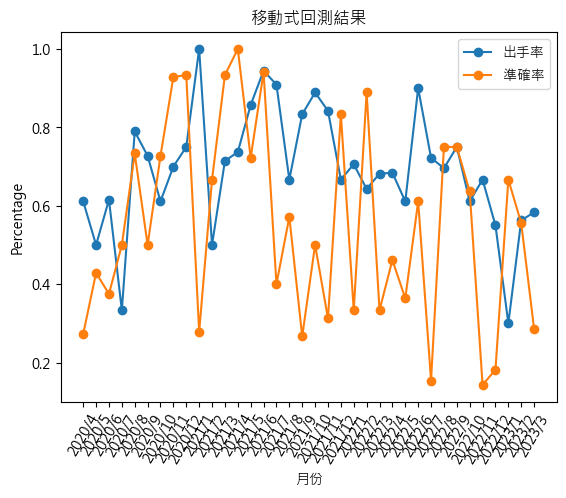

In [ ]:
l1 = plt.plot(months, go_list, label="出手率")
plt.setp(l1, marker='o')
l2 = plt.plot(months, acc_list, label="準確率")
plt.setp(l2, marker='o')

xloc = np.arange(0, len(months), 3)
plt.xticks(rotation=60)
plt.title("移動式回測結果")
plt.xlabel("月份")
plt.ylabel("Percentage")
plt.legend(loc='best')

plt.show()